## Special matrices and solving linear systems

In [12]:
# the required imports
import numpy as np
from scipy.linalg import lu, solve_triangular
from numpy.linalg import qr, svd, inv
import matplotlib.pyplot as plt
from skimage.transform import radon, rescale
from ipywidgets import interactive, IntSlider

_setup some helper functions_

In [13]:
# helper function to load Shepp-Logan phantom 
def getPhantom(size):
    if size == 128:
        return plt.imread('phantom.png')
    elif size == 32:
        p = plt.imread('phantom.png')
        return rescale(p, scale=1/4, mode='reflect', multichannel=False)
    elif size == 4:
        p = plt.imread('phantom.png')
        return rescale(p, scale=1/32, mode='reflect', multichannel=False)
    else:
        raise NotImplementedError


# compute the matrix of the Radon transform (and also do the right hand side)
def computeRadonMatrixRhs(image, numberOfAngles):
    angles = np.linspace(0, 180, numberOfAngles) 
    
    sizeX, sizeY = image.shape
    if sizeX != sizeY:                   # this works only for square images!
        raise ValueError
    size = image.size
    
    M = np.zeros((angles.size * sizeX, size)) # initialize matrix with zeros
    basisVec = np.zeros(size)            # initialize basis vector with zeros
    
    for i in range(size):
        basisVec[i] = 1                                # set to i-th basis vector
        bVecAsImg = basisVec.reshape(sizeX, sizeY)     # reshape to a 2d image
        
        column = radon(bVecAsImg, angles, circle=True) # compute Radon transform of this basis vector
        M[:, i] = column.flatten()                     # linearize and put into matrix as i-th column
        
        basisVec[i] = 0                                # reset basis vector to zero
        
    rhs = radon(image, angles, circle=True) # compute the right hand side
    return M, rhs.flatten()

### Setup our matrix (and right-hand side)

A has size =  (1024, 1024) , and b has size =  1024


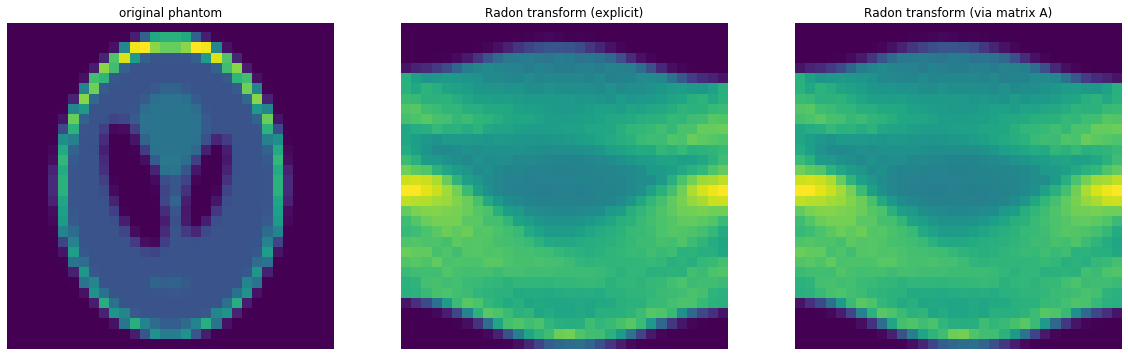

In [14]:
image = getPhantom(32)

plt.figure(figsize=(20,6))
plt.subplot(1, 3, 1, title='original phantom')
plt.imshow(image); plt.axis('off')

A, b = computeRadonMatrixRhs(image, 32)
print("A has size = ", A.shape, ", and b has size = ", b.size)

plt.subplot(1, 3, 2, title='Radon transform (explicit)')
plt.imshow( b.reshape(32, 32) ); plt.axis('off')

plt.subplot(1, 3, 3, title='Radon transform (via matrix A)')
plt.imshow( A.dot(image.flatten()).reshape(32, 32) ); plt.axis('off')
plt.show()

### LU decomposition

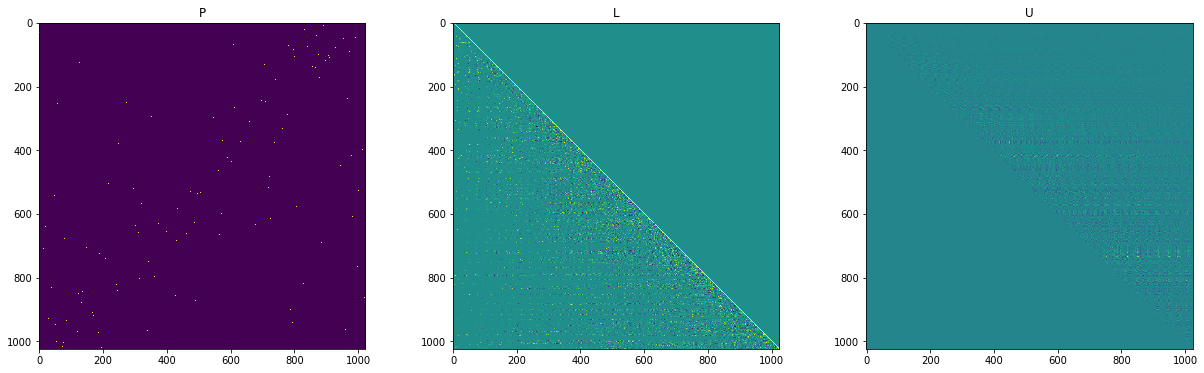

In [17]:
# compute pivoted LU decomposition
P, L, U = lu(A)
U[1023, 1023] = 0.00000000001 # band-aid fix as matrix is close to singular...

# show the matrices
plt.figure(figsize=(21,6))
plt.subplot(1, 3, 1, title='P'); plt.imshow(P); 
plt.subplot(1, 3, 2, title='L'); plt.imshow(L); 
plt.subplot(1, 3, 3, title='U'); plt.imshow(U); 
plt.show()

# compute the solution of Ax = b in two steps:
# 1. solve Lz = P^Tb
z = solve_triangular(L, np.dot(P.T, b), lower=True) 
# 2. solve Ux = z
solutionLU = solve_triangular(U, z, lower=False)

### QR decomposition

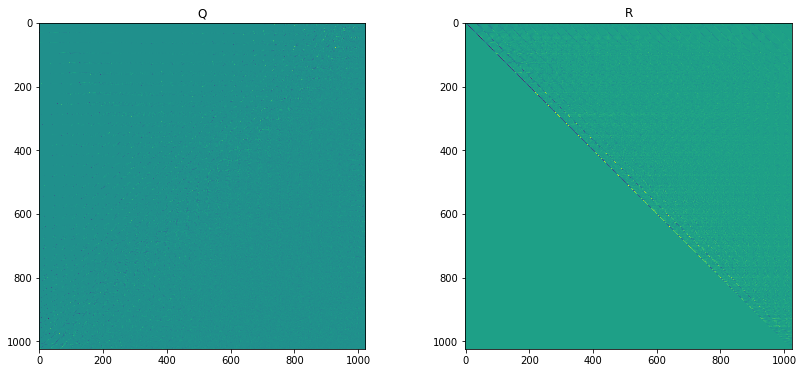

In [18]:
# compute QR decomposition
Q, R = qr(A)

# show the matrices
plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1, title='Q'); plt.imshow(Q); #plt.axis('off')
plt.subplot(1, 2, 2, title='R'); plt.imshow(R); #plt.axis('off')
plt.show()

# compute the solution of Ax = b by solving Rx = Q^Tb
solutionQR = solve_triangular(R, np.dot(Q.T, b))

###  SVD decomposition

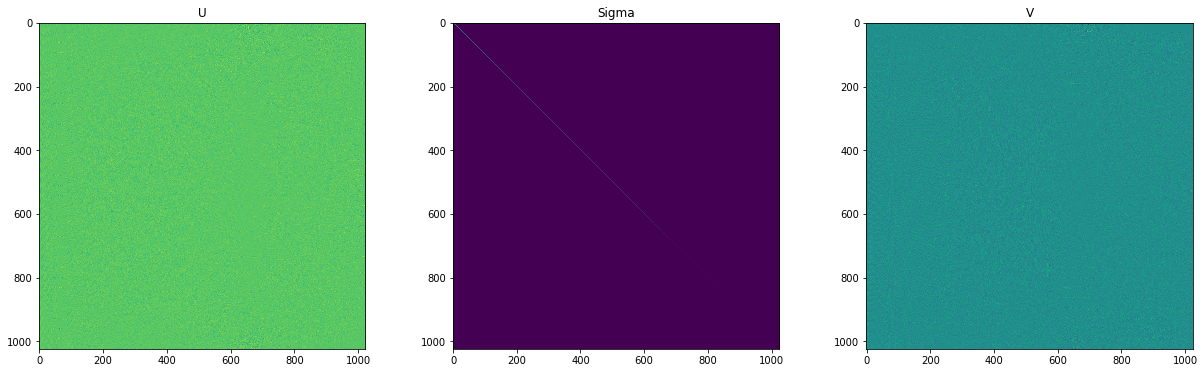

In [19]:
# compute SVD decomposition
U, Sigma, Vt = svd(A)
Sigma = np.diag(Sigma)

# show the matrices
plt.figure(figsize=(21,6))
plt.subplot(1, 3, 1, title='U'); plt.imshow(U); #plt.axis('off')
plt.subplot(1, 3, 2, title='Sigma'); plt.imshow(Sigma); #plt.axis('off')
plt.subplot(1, 3, 3, title='V'); plt.imshow(Vt.T); #plt.axis('off')
plt.show()

# compute the solution of Ax = b as V Sigma^-1 U^T b
SigmaInv = inv(Sigma)
solutionSVD = np.dot(Vt.T, np.dot(SigmaInv, np.dot(U.T, b)))

### Compare the decompositions

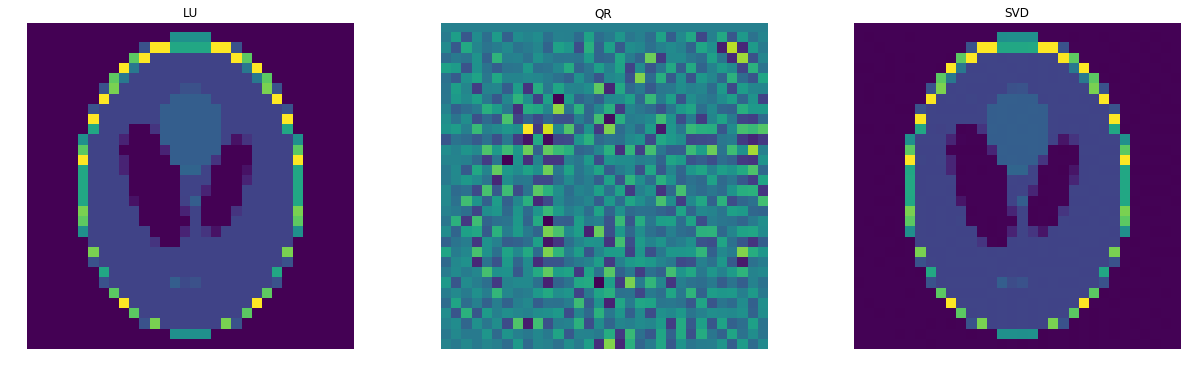

In [7]:
# compare the LU, QR, SVD solutions
plt.figure(figsize=(21,6))
plt.subplot(1, 3, 1, title='LU'); plt.imshow(solutionLU.reshape(32, 32)); plt.axis('off')
plt.subplot(1, 3, 2, title='QR'); plt.imshow(solutionQR.reshape(32, 32)); plt.axis('off')
plt.subplot(1, 3, 3, title='SVD'); plt.imshow(solutionSVD.reshape(32, 32)); plt.axis('off')
plt.show()

### What happens when you add noise?

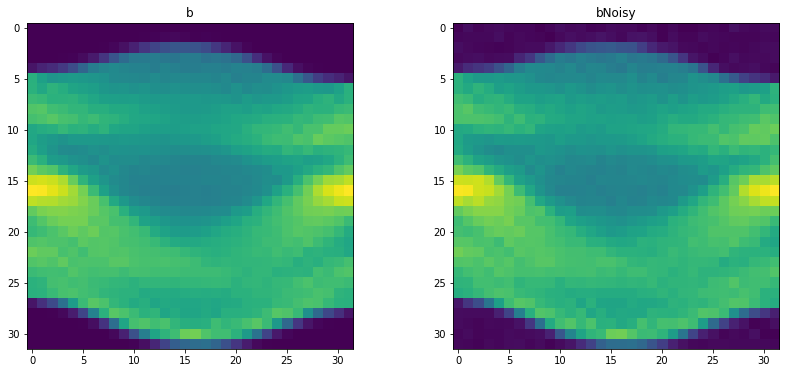

In [20]:
# add some white noise to right-hand-side b
noise = max(b) * 0.01 * np.random.randn(b.size)
bNoisy = b + noise

# show the noisy b
plt.figure(figsize=(14,6))
plt.subplot(1,2,1,title='b'); plt.imshow(b.reshape(32,32)); #plt.axis('off')
plt.subplot(1,2,2,title='bNoisy'); plt.imshow(bNoisy.reshape(32,32)); #plt.axis('off')
plt.show()

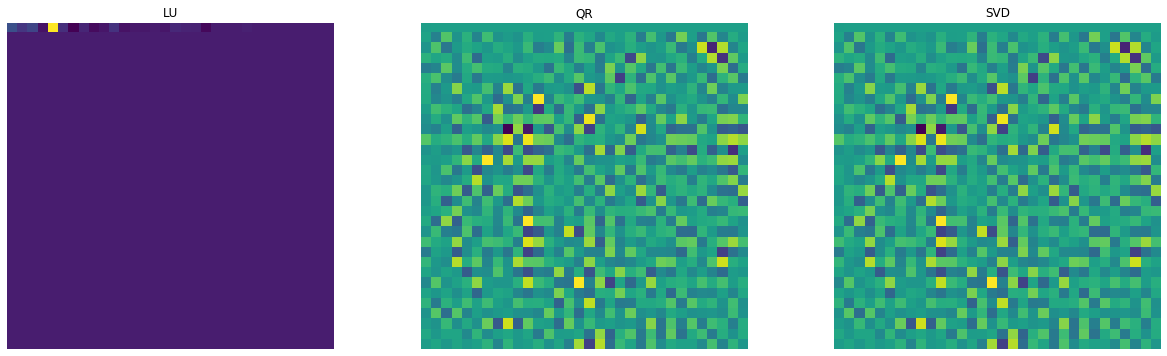

In [21]:
# compute the solutions again for bNoisy
# LU
zNoisy = solve_triangular(L, np.dot(P.T, bNoisy), lower=True) 
solutionLUNoisy = solve_triangular(U, zNoisy, lower=False)
# QR
solutionQRNoisy = solve_triangular(R, np.dot(Q.T, bNoisy))
# SVD
solutionSVDNoisy = np.dot(Vt.T, np.dot(SigmaInv, np.dot(U.T, bNoisy)))

# compare the LU, QR, SVD solutions
plt.figure(figsize=(21,6))
plt.subplot(1, 3, 1, title='LU'); plt.imshow(solutionLUNoisy.reshape(32, 32)); plt.axis('off')
plt.subplot(1, 3, 2, title='QR'); plt.imshow(solutionQRNoisy.reshape(32, 32)); plt.axis('off')
plt.subplot(1, 3, 3, title='SVD'); plt.imshow(solutionSVDNoisy.reshape(32, 32)); plt.axis('off')
plt.show()

### Truncated SVD

In [22]:
# show the results of truncated SVD
def truncSVD(k):
    truncSigma = np.copy(SigmaInv)
    truncSigma[k:,:] = 0; truncSigma[:,k:] = 0 # truncate at k

    truncSVD = np.dot(Vt.T, np.dot(truncSigma, np.dot(U.T, bNoisy)))

    plt.figure(figsize=(14,6))
    plt.subplot(1, 2, 1, title='SVD'); plt.imshow(solutionSVDNoisy.reshape(32,32)); plt.axis('off')
    plt.subplot(1, 2, 2, title='Truncated SVD'); plt.imshow(truncSVD.reshape(32,32)); plt.axis('off')
    plt.show()
    
iplot = interactive(truncSVD, k=IntSlider(min=1, max=1024, step=1, value=800, continuous_update=False))
iplot

interactive(children=(IntSlider(value=800, continuous_update=False, description='k', max=1024, min=1), Output(…